In [22]:
import os
from langfuse.langchain import CallbackHandler
from dotenv import load_dotenv

load_dotenv()
langfuse_handler = CallbackHandler()

In [23]:
import os
from dotenv import load_dotenv
import pandas as pd
import sqlite3
from langchain_groq import ChatGroq
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import FAISS
from langchain_milvus import Milvus

from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from typing import Annotated, List, Literal
from langchain_core.documents import Document
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
import glob
from langfuse.langchain import CallbackHandler
from langsmith import traceable

load_dotenv()
langfuse_handler = CallbackHandler()

os.environ["LANGCHAIN_PROJECT"] = "excel_agent"
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY", "")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "")

In [24]:
data_folder = r"./data/imdb"
csv_files = glob.glob(os.path.join(data_folder, '**/*.csv'), recursive=True)
excel_files = glob.glob(os.path.join(data_folder, '**/*.xlsx'), recursive=True)
excel_files += glob.glob(os.path.join(data_folder, '**/*.xls'), recursive=True)
all_files = csv_files + excel_files
print(f"Files found: {len(all_files)}")

# Check if files exist
if len(all_files) == 0:
    raise FileNotFoundError(f"No CSV or Excel files found in '{data_folder}'. Please check the path and add data files.")

Files found: 1


In [25]:
def get_file_info(dataframe, file_path):
    return {
        'columns': dataframe.columns.tolist(),
        'total_rows': len(dataframe),
        'file_path': file_path
    }

def load_file(file_path):
    try:
        if file_path.endswith('.csv'):
            return pd.read_csv(file_path)
        elif file_path.endswith(('.xlsx', '.xls')):
            return pd.read_excel(file_path)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    return None

def create_documents_from_file(file_path):
    dataframe = load_file(file_path)
    if dataframe is None or dataframe.empty:
        return [], None
    
    file_info = get_file_info(dataframe, file_path)
    documents = []
    
    for row_number, row_data in dataframe.iterrows():
        content_lines = []
        for column_name in dataframe.columns:
            cell_value = row_data[column_name]
            if pd.notna(cell_value):
                content_lines.append(f"{column_name}: {cell_value}")
        
        if content_lines:
            doc = Document(
                page_content="\n".join(content_lines),
                metadata={
                    'source': file_path,
                    'row_number': row_number,
                    'filename': os.path.basename(file_path)
                }
            )
            documents.append(doc)
    
    return documents, file_info

In [26]:
all_documents = []
all_file_info = []

for file_path in all_files:
    docs, info = create_documents_from_file(file_path)
    if docs:
        all_documents.extend(docs)
        all_file_info.append(info)

print(f"Documents created: {len(all_documents)}")

# Check if documents were created
if len(all_documents) == 0:
    raise ValueError("No documents were created. Please check if your data files contain valid data.")

Documents created: 1000


In [7]:
schema_description = "Available Data:\n\n"
for info in all_file_info:
    filename = os.path.basename(info['file_path'])
    schema_description += f"File: {filename}\n"
    schema_description += f"Columns: {', '.join(info['columns'])}\n"
    schema_description += f"Rows: {info['total_rows']}\n\n"

In [ ]:
# from langchain_milvus import Milvus
# from langchain_openai import OpenAIEmbeddings

# embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# # Use from_documents() instead of from_texts()
# vectorstore = Milvus.from_documents(
#     documents=all_documents,  # Pass Document objects directly
#     embedding=embeddings,
#     connection_args={"uri": "http://localhost:19530"},
#     collection_name="rag_collection"
# )

# retriever = vectorstore.as_retriever(search_kwargs={"k": 7})
# print("Vector store ready")

Vector store ready


In [27]:
from langchain_milvus import Milvus
from langchain_openai import OpenAIEmbeddings
from pymilvus import utility, connections

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Connect to Milvus
connections.connect(uri="http://localhost:19530")

collection_name = "rag_collection"

# Check if collection exists
if utility.has_collection(collection_name):
    print(f"Collection '{collection_name}' already exists. Loading existing collection...")
    
    # Load existing collection
    vectorstore = Milvus(
        embedding_function=embeddings,
        connection_args={"uri": "http://localhost:19530"},
        collection_name=collection_name
    )
    print("Loaded existing vector store")
else:
    print(f"Collection '{collection_name}' doesn't exist. Creating new collection...")
    
    # Create new collection
    vectorstore = Milvus.from_documents(
        documents=all_documents,
        embedding=embeddings,
        connection_args={"uri": "http://localhost:19530"},
        collection_name=collection_name
    )
    print(f"Created new vector store with {len(all_documents)} documents")

retriever = vectorstore.as_retriever(search_kwargs={"k": 7})
print("Vector store ready")

Collection 'rag_collection' already exists. Loading existing collection...
Loaded existing vector store
Vector store ready


In [28]:
from pymilvus import utility, connections

# Helper functions to manage Milvus collections

def list_collections():
    """List all collections in Milvus"""
    connections.connect(uri="http://localhost:19530")
    collections = utility.list_collections()
    print(f"Collections in Milvus: {collections}")
    return collections

def drop_collection(collection_name):
    """Drop a specific collection"""
    connections.connect(uri="http://localhost:19530")
    if utility.has_collection(collection_name):
        utility.drop_collection(collection_name)
        print(f"Dropped collection: {collection_name}")
    else:
        print(f"Collection '{collection_name}' doesn't exist")

def get_collection_stats(collection_name):
    """Get stats for a collection"""
    from pymilvus import Collection
    connections.connect(uri="http://localhost:19530")
    
    if utility.has_collection(collection_name):
        collection = Collection(collection_name)
        collection.load()
        num_entities = collection.num_entities
        print(f"Collection '{collection_name}' has {num_entities} documents")
        return num_entities
    else:
        print(f"Collection '{collection_name}' doesn't exist")
        return 0

# Usage examples (uncomment to use):
list_collections()
get_collection_stats("rag_collection")
# drop_collection("rag_collection")  # Use with caution!

Collections in Milvus: ['rag_collection']
Collection 'rag_collection' has 2000 documents


2000

In [29]:
from pymilvus import connections, Collection

# Connect to Milvus
connections.connect("default", uri="http://localhost:19530")

# Load your collection by name
collection = Collection("rag_collection")

# Display collection info
print("\n=== Milvus Collection Info ===")
print(f"Name: {collection.name}")
print(f"Description: {collection.description}")
print(f"Number of entities: {collection.num_entities}")

print("\n=== Schema Fields ===")
for field in collection.schema.fields:
    print(f"- {field.name}: {field.dtype}, is_primary={field.is_primary}")

print("\n=== Indexes ===")
for index in collection.indexes:
    print(index)

# Optional: show index and metric details
indexes = collection.indexes
if indexes:
    for idx in indexes:
        print(f"\nIndex field: {idx.field_name}")
        print(f"Index params: {idx.params}")




=== Milvus Collection Info ===
Name: rag_collection
Description: 
Number of entities: 2000

=== Schema Fields ===
- text: 21, is_primary=False
- pk: 5, is_primary=True
- vector: 101, is_primary=False
- source: 21, is_primary=False
- row_number: 5, is_primary=False
- filename: 21, is_primary=False

=== Indexes ===

Index field: vector
Index params: {'index_type': 'AUTOINDEX', 'metric_type': 'L2'}


In [30]:
sqlite_connection = sqlite3.connect(':memory:')

table_info = {}
for file_path in all_files:
    dataframe = load_file(file_path)
    if dataframe is not None:
        table_name = os.path.splitext(os.path.basename(file_path))[0].replace(' ', '_').replace('-', '_')
        dataframe.to_sql(table_name, sqlite_connection, if_exists='replace', index=False)
        table_info[table_name] = dataframe.columns.tolist()

sql_schema = "Tables:\n\n"
for table_name, columns in table_info.items():
    sql_schema += f"Table: {table_name}\n"
    sql_schema += f"Columns: {', '.join(columns)}\n\n"

print(f"Database ready: {len(table_info)} tables")

Database ready: 1 tables


In [31]:
def retrieve_from_vectors(query: str) -> str:
    retrieved_docs = retriever.invoke(query)
    return "\n\n---\n\n".join([doc.page_content for doc in retrieved_docs])

def run_sql_query(question: str, retry_count: int = 0) -> str:
    if retry_count > 2:
        return "Unable to generate valid SQL query after multiple attempts"
    
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    
    prompt = f"""Generate ONLY a valid SQLite query. No explanations, no markdown, no extra text.

{sql_schema}

Question: {question}

Return ONLY the SQL query without any formatting or code blocks."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    sql_query = response.content.strip()
    
    sql_query = sql_query.replace("```sql", "").replace("```", "").strip()
    
    lines = sql_query.split('\n')
    clean_lines = []
    for line in lines:
        line = line.strip()
        if line and not line.startswith('--') and not line.startswith('#'):
            clean_lines.append(line)
    sql_query = ' '.join(clean_lines)
    
    sql_query = sql_query.split(';')[0].strip()
    
    cursor = sqlite_connection.cursor()
    
    try:
        cursor.execute(sql_query)
        results = cursor.fetchall()
        columns = [desc[0] for desc in cursor.description]
        
        result_text = f"SQL: {sql_query}\n\nResults ({len(results)} rows):\n"
        result_text += f"Columns: {', '.join(columns)}\n\n"
        
        for row in results[:20]:
            result_text += str(row) + "\n"
        
        return result_text
    except Exception as e:
        return run_sql_query(question, retry_count + 1)

In [32]:
class AgentState(TypedDict):
    messages: Annotated[List, add_messages]
    needs_sql: bool
    context: str

In [33]:
def decide_route(state: AgentState):
    print("[ROUTE]")
    
    user_message = state["messages"][0].content.lower()
    
    # SQL keywords for aggregation/counting
    sql_keywords = ['count', 'total', 'sum', 'average', 'avg', 'max', 'min', 
                    'top', 'highest', 'lowest', 'how many', 'all', 'most', 'least']
    
    needs_sql = any(keyword in user_message for keyword in sql_keywords)
    
    return {"needs_sql": needs_sql}

def retrieve_vectors(state: AgentState):
    print("[RETRIEVE]")
    
    query = state["messages"][0].content
    context = retrieve_from_vectors(query)
    
    return {"context": context}

def execute_sql(state: AgentState):
    print("[SQL]")
    
    query = state["messages"][0].content
    context = run_sql_query(query)
    
    return {"context": context}

def generate_answer(state: AgentState):
    print("[GENERATE]")
    
    context = state.get("context", "")
    question = state["messages"][0].content
    
    system_msg = f"""Answer using the context provided.

Database Info:
{schema_description}

Be concise and accurate."""
    
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    
    response = llm.invoke(
        [
            SystemMessage(content=system_msg),
            HumanMessage(content=f"Context: {context}\n\nQuestion: {question}")
        ],
        config={"callbacks": [langfuse_handler]}
    )
    
    # Return answer directly as AIMessage
    return {"messages": [AIMessage(content=response.content)]}

In [34]:
def route_after_decision(state: AgentState) -> Literal["execute_sql", "retrieve_vectors"]:
    if state.get("needs_sql", False):
        return "execute_sql"
    else:
        return "retrieve_vectors"

In [35]:
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("decide_route", decide_route)
workflow.add_node("retrieve_vectors", retrieve_vectors)
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("generate_answer", generate_answer)

# Add edges
workflow.add_edge(START, "decide_route")

workflow.add_conditional_edges(
    "decide_route",
    route_after_decision,
    {
        "retrieve_vectors": "retrieve_vectors",
        "execute_sql": "execute_sql"
    }
)

workflow.add_edge("retrieve_vectors", "generate_answer")
workflow.add_edge("execute_sql", "generate_answer")
workflow.add_edge("generate_answer", END)

graph = workflow.compile()

print("Simplified graph ready")

Simplified graph ready


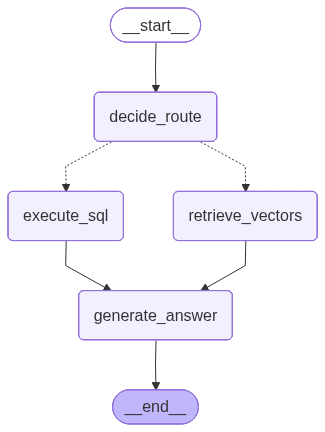

In [36]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print("Graph visualization not available")

In [37]:
questions = [
    "Which movie deals with a young girl experiencing an out-of-body dilemma after a tragic accident forces her to choose between life and death?",
    "Which movie explores a father’s fight against a supernatural illness threatening his child in a rural village?",
    "Which uplifting Bollywood movie follows a curious outsider asking innocent questions?",
    "Which movie shows how teamwork inside a military command leads to ethical decisions protecting innocent life?",
    "Which movie explores how a blind man regains sight but loses clarity in life due to superficial obsession?",
    "Which movie has the highest IMDb rating in the dataset?",
    "Find the top 3 highest-revenue movies released after 2010, sorted descending.",
    "How many movies have Runtime > 150 minutes AND rating ≥ 8.0?",
    "Which 3 directors have directed the most movies in the dataset?",
    "Count all movies belonging to the Sci-Fi genre (even if mixed)."
]

import time

for question in questions:
    print(f"\nQuestion: {question}")
    print("="*50)
    
    result = graph.invoke(
        {"messages": [HumanMessage(content=question)]},
        config={"callbacks": [langfuse_handler]}
    )
    
    print(f"\nAnswer:\n{result['messages'][-1].content}")
    print("\n")
    time.sleep(10)


Question: Which movie deals with a young girl experiencing an out-of-body dilemma after a tragic accident forces her to choose between life and death?
[ROUTE]
[RETRIEVE]
[GENERATE]

Answer:
The movie that deals with a young girl experiencing an out-of-body dilemma after a tragic accident forces her to choose between life and death is "If I Stay."



Question: Which movie explores a father’s fight against a supernatural illness threatening his child in a rural village?
[ROUTE]
[RETRIEVE]
[GENERATE]

Answer:
The movie that explores a father's fight against a supernatural illness threatening his child in a rural village is "Goksung."



Question: Which uplifting Bollywood movie follows a curious outsider asking innocent questions?
[ROUTE]
[RETRIEVE]
[GENERATE]

Answer:
The uplifting Bollywood movie that follows a curious outsider asking innocent questions is "PK," directed by Rajkumar Hirani.



Question: Which movie shows how teamwork inside a military command leads to ethical decisions